<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/11_cnn_pytorch/13_semi_supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 半教師付き学習

---

DNNは一般的に，大量の教師ラベル付きデータを用いて学習を行うことで高い認識性能を発揮しています．しかし，教師ラベルは人手によって付与されるため，データ数に比例して人的コストが増えてしまいます．また，問題設定によっては画像に対して1ピクセル毎のラベル付けが必要な場合やデータ自体を集めることが困難な場合もあります．これらのことから期待される問題設定やタスクに対して理想的なデータセット（大量の教師ラベル付きデータ）を用意するのは多くの場合困難です．このような問題を解決する学習方法の１つとして「半教師付き学習」があります．

<img src="https://dl.dropboxusercontent.com/s/cw3nd3iq0ggb01g/sup.png" width = 57%>

半教師付き学習（Semi-supervised Learning）は，教師ラベル付きデータと教師ラベルなしデータの両方を含むデータセットを利用した学習方法です．問題設定として一般的に，教師ラベル付きデータと比較して大量の教師ラベルなしデータが用意されています．

<img src="https://dl.dropboxusercontent.com/s/wljsvzdlb9f9ivn/semi_sup.png" width = 57%>

半教師付き学習として様々な学習方法が提案されてますが，ここではConsistency Regularizationという枠組みについて紹介します．

# Consistency Regularization

Consistency Regularizationは，教師ラベルなしデータに対する出力が一貫性を持つように学習をします．ここで，一貫性とは同一画像に対してノイズなどによって出力が左右されないことを表します．
ネットワークはノイズや幾何学変換などに頑健な特徴抽出器を獲得するため，教師ラベルを利用しないものの正解率の向上に寄与します．

<img src="https://dl.dropboxusercontent.com/s/40zfvwq2eksud9k/CR.png" width = 57%>

## 学習方法
Consistency Regularizationは，ネットワークに入力されたデータが教師ラベルを持つか否かによって学習の流れが異なります．

### 教師ラベル付きデータ
1. ネットワークにデータを入力
2. ネットワークが出力した確率分布と教師ラベルからCross Entropyを計算

### 教師ラベルなしデータ
1. データに対して摂動（ノイズやデータ増幅）を付与
2. データ（または摂動を付与したデータ）と摂動を付与したデータをネットワークに入力
3. ネットワークが出力した2つの確率分布の相違度を計算

ネットワークは，「教師ラベル付きデータから算出したCross Entropy」と「教師ラベルなしデータから算出した確率分布の相違度」を損失関数として学習が行われます．
確率分布の相違度を小さくするように学習が行われるため，摂動に左右されないネットワークを獲得します．
学習の流れは多くの場合共通ですが，摂動の内容や摂動の付与方法，確率分布間の相違度の計算方法などによって以下のような様々な手法が提案されています．

<img src="https://dl.dropboxusercontent.com/s/t862ozembfzb1vi/semi_sup_list.png" width = 65%>


# 畳み込みニューラルネットワークの半教師付き学習
クラス分類問題において，半教師付き学習によってネットワークを学習します．\
以降では，教師ラベル付きデータを教師付きデータ，教師ラベルなしデータを教師なしデータと呼びます．

プログラムの構成は以下の通りになります．
1. データセットの定義　　　：教師付きデータのデータセットと教師なしデータのデータセットを定義します．
2. ネットワークの定義　　　：学習を行うネットワークを定義します，
3. 教師付き学習による評価　：教師付きデータセットとネットワークを用いて教師付き学習を行います．
4. 半教師付き学習による評価：教師付きデータセット，教師なしデータセットとネットワークを用いて半教師付き学習を行います．

## モジュールの読み込み

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
from time import time
from PIL import Image
from collections import defaultdict
from sklearn.model_selection import StratifiedShuffleSplit

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
#import torchsummary
from torch.utils.data import Sampler
from torch.utils.data import SubsetRandomSampler, Subset, Dataset

## データセットの準備

### データ増幅の定義
ここでは，教師付きデータに対するデータ増幅，教師なしデータに摂動として付与するデータ増幅，評価用データに対するデータ増幅の3つを定義します．

In [ ]:
# 教師付きデータに対するデータ増幅
transform_A = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

# 教師なしデータに対するデータ増幅（摂動）
transform_B = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.Pad(4, padding_mode="reflect"), 
    transforms.RandomCrop(32), 
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

# 評価用データに対するデータ増幅
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

### ベースとなるデータセットの定義
半教師付き学習手法の評価には，一般的に教師付き学習に用いるベンチマークデータセットが利用されます．\
データセットとして，一般物体認識用データセットであるCIFAR-10を用います．\
CIFAR-10は，10クラス（飛行機，自動車，鳥，猫，鹿，犬，カエル，馬，船，トラック）の画像から構成されるデータセットです．

In [ ]:
# 学習用データ
total_trainset = torchvision.datasets.CIFAR10(root="./dataset/CIFAR-10", train=True,  download=True, transform=transform_A)
unsup_trainset = torchvision.datasets.CIFAR10(root="./dataset/CIFAR-10", train=True,  download=True, transform=None)

# 評価用データ
testset = torchvision.datasets.CIFAR10(root="./dataset/CIFAR-10", train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### データセットの分割
先程定義したデータセットは全て教師付きデータであるため，まず初めにデータセットを教師付きデータと教師なしデータに分割します．
ここでは，教師付きデータと教師なしデータに割り振るデータのidのみを取得します．
教師なしデータの数はStratifiedShuffleSplitの引数「test_size」で決定し，教師付きデータの数は全体のデータ数からtest_sizeとして指定したデータ数の差分となります．
今回は，教師付きデータ100枚，教師なしデータ49,900枚とします．

In [ ]:
# StratifiedShuffleSplit：データをシャッフルして分割
sss = StratifiedShuffleSplit(n_splits=1, test_size=49900, random_state=0)

# list(range(len(total_trainset)))：データidのリスト，total_trainset.targets：データidに対応するラベル
sss = sss.split(list(range(len(total_trainset))), total_trainset.targets)

# 教師付きデータと教師なしデータのデータidを取得
label_idx, unlabel_idx = next(sss)

### Datasetの定義
Consistency Regularizationを行うには，教師なしデータ１枚につき，摂動を施した２枚の画像を取得する必要があります．\
データセットからデータを取得するアルゴリズムはDatasetクラスにより制御します．今回は自作のDatasetクラスを利用します．

In [ ]:
# 自作 Dataset
class UnsupervisedDataset(Dataset):
    def __init__(self, dataset, transform_1, transform_2):
        self.dataset = dataset          # データセット
        self.transform_1 = transform_1  # 摂動１
        self.transform_2 = transform_2  # 摂動２

    def __getitem__(self, index):
        img, _ = self.dataset[index]  # データセットからデータを取得

        # 同一画像から2つの画像を作成
        img1 = self.transform_1(img)  # データに摂動１を適用
        img2 = self.transform_2(img)  # データに摂動２を適用

        return img1, img2

    def __len__(self):
        return len(self.dataset)  # このクラスに対してlen()を行った際にデータセットのデータ数を返すように設定

### データセットの定義
「データセットの分割」で取得したデータidを用いて教師付きデータセットと教師なしデータセットを定義します．

In [ ]:
# 教師付きデータセットを作成（データ増幅はtotal_trainsetで設定したものを実行）
trainset = Subset(total_trainset, label_idx)
train_labels          = [total_trainset.targets[idx] for idx in label_idx]
trainset.train_labels = train_labels

# 教師なしデータセットを作成
otherset = Subset(unsup_trainset, unlabel_idx)
otherset = UnsupervisedDataset(otherset, transform_B, transform_B)  # 第１引数：教師なしデータ，第２引数：摂動１，第３引数：摂動２

In [ ]:
print("データ数")
print("教師付きデータ：", len(trainset))
print("教師なしデータ：", len(otherset))

データ数
教師付きデータ： 100
教師なしデータ： 49900


### Samplerの定義
ネットワークの学習時にデータセットから学習用データをランダムに取得する必要があります．
今回は，教師付きデータが少ないため，ミニバッチ内の教師付きデータ数を小さく設定します．
そのため，教師付きデータを各クラスからバランスよく取得することを考えます．
データセットの中から取得するデータを決定するアルゴリズムはSamplerクラスにより制御します．
今回は自作のSamplerクラスを利用します．

In [ ]:
# 自作 Sampler
class StratifiedSampler(Sampler):
    def __init__(self, labels):
        self.idx_by_lb = defaultdict(list)
        for idx, lb in enumerate(labels):
            self.idx_by_lb[lb].append(idx)

        self.size = len(labels)

    def __len__(self):
        return self.size

    def __iter__(self):
        songs_list = []
        artists_list = []
        for lb, v in self.idx_by_lb.items():
            for idx in v:
                songs_list.append(idx)
                artists_list.append(lb)

        shuffled = spotifyShuffle(songs_list, artists_list)
        return iter(shuffled)


def fisherYatesShuffle(arr):
    for i in range(len(arr)-1, 0, -1):
        j = random.randint(0, i)
        arr[i], arr[j] = arr[j], arr[i]
    return arr


def spotifyShuffle(songs_list, artists_list):
    artist2songs = defaultdict(list)
    for artist, song in zip(artists_list, songs_list):
        artist2songs[artist].append(song)
    songList = []
    songsLocs = []
    for artist, songs in artist2songs.items():
        songs = fisherYatesShuffle(songs)
        songList += songs
        songsLocs += get_locs(len(songs))
    return [songList[idx] for idx in argsort(songsLocs)]


def get_locs(n):
    percent = 1. / n
    locs = [percent * random.random()]
    last = locs[0]
    for i in range(n - 1):
        value = last + percent * random.uniform(0.8, 1.2)
        locs.append(value)
        last = value
    return locs


def argsort(seq):
    return [i for i, j in sorted(enumerate(seq), key=lambda x:x[1])]

### Dataloaderの定義
今回はバッチサイズを512（ラベルありデータ10枚，ラベルなしデータ251枚 × 摂動により2倍）とします．

In [ ]:
# 教師付きデータセット用 Dataloader
train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size=10, 
                                           shuffle=False,   # Samplerを利用するためFalse
                                           num_workers=16, 
                                           pin_memory=True,
                                           sampler=StratifiedSampler(trainset.train_labels),  # 自作のSampler
                                           drop_last=True)

# 教師なしデータセット用 Dataloader
unsup_loader = torch.utils.data.DataLoader(otherset, 
                                           batch_size=251,
                                           shuffle=True,    # Samplerを利用しないためTure
                                           num_workers=16, 
                                           pin_memory=True, 
                                           drop_last=True)

# 評価データ用 Dataloader
test_loader  = torch.utils.data.DataLoader(testset, 
                                           batch_size=1000,
                                           shuffle=False, 
                                           num_workers=16, 
                                           pin_memory=True, 
                                           drop_last=False)

### Samplerによるデータ取得の確認
ここでは先程定義した自作Samplerクラスによってdataloaderからクラスのバランスよく教師付きデータが取得されているのかを確認します．

In [ ]:
tmp = train_loader.__iter__()
for _ in range(5):
    data1, label1 = tmp.next()      # 教師付きデータのDataloaderからデータと教師ラベルを取得
    print(np.sort(label1.numpy()))  # 教師ラベルをソートして表示

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 6 7 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


### データの可視化
ここでは先程定義した摂動と自作Datasetクラスによって１つの教師なしデータに対してどのような摂動が与えられたのか（視覚的にどう違うのか）を確認します．

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


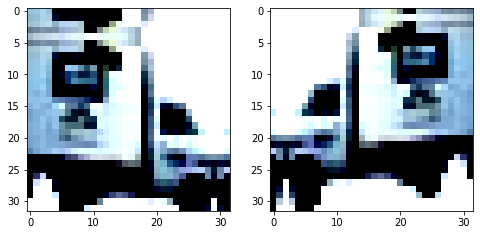

In [ ]:
tmp = unsup_loader.__iter__()
data1, data2 = tmp.next()      # 教師なしデータのDataloaderから摂動を付与した２つのデータを取得

# データの可視化
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))

ax1.imshow(data1[0].permute(1,2,0))
ax2.imshow(data2[0].permute(1,2,0))

fig.show()

## ネットワークの定義
畳み込みニューラルネットワークの定義をします．\
ここでは，11.knowledge_distillationや12.deep_mutual_learningで使用したネットワークと同様のものを利用します．

In [ ]:
class CNN(nn.Module):
    def __init__(self, widen_factor=1):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16*widen_factor, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16*widen_factor, 32*widen_factor, kernel_size=3, stride=1, padding=1)
        self.l1 = nn.Linear(8*8*32*widen_factor, 1024*widen_factor)
        self.l2 = nn.Linear(1024*widen_factor, 1024*widen_factor)
        self.l3 = nn.Linear(1024*widen_factor, 10)
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        h = self.pool(self.act(self.conv1(x)))
        h = self.pool(self.act(self.conv2(h)))
        h = h.view(h.size()[0], -1)
        h = self.act(self.l1(h))
        h = self.act(self.l2(h))
        h = self.l3(h)
        return h

## 教師付き学習による学習と評価
半教師付き学習による学習結果と比較をするために，教師付きデータのみを用いた教師付き学習を行います．

### 学習条件の設定

In [ ]:
# エポック数の設定
NUM_EPOCH = 25

# ネットワークの用意
net_sup = CNN(widen_factor=1).cuda()

# オプティマイザの設定
optimizer = torch.optim.SGD(net_sup.parameters(), lr=0.01, momentum=0.9)

### 学習と評価

In [ ]:
# ネットワークを学習モードへ変更
net_sup.train()

start = time()
for epoch in range(1, NUM_EPOCH+1):
    # ネットワークの学習 ----------------------------------------------------------
    # ネットワークを学習モードへ変更
    net_sup.train()

    # ログ用の設定
    sum_loss = 0.0
    count = 0
    
    for image, label in train_loader:
        # 学習データをGPUへ
        image = image.cuda()
        label = label.cuda()
        
        # ネットワークへ学習データを入力
        logits = net_sup(image)
        
        # 損失の計算(教師付きデータ)
        loss = F.cross_entropy(logits, label)
        
        # パラメータの更新
        net_sup.zero_grad()
        loss.backward()
        optimizer.step()
        
        # ログ用に損失と精度の取得
        sum_loss += loss.item()
        
        pred   = torch.argmax(logits, dim=1)
        count += torch.sum(pred == label)
        
    # ログの表示
    print(f"epoch: {epoch},\
  mean loss: {round(sum_loss/len(train_loader), 3)},\
  mean accuracy: {round(count.item()/len(train_loader.dataset), 2)},\
  elapsed_time :{round(time()-start, 2)}")

    # ネットワークの評価 ----------------------------------------------------------
    if epoch%5 == 0:  # 5 epoch毎に評価
        # ネットワークを評価モードへ変更
        net_sup.eval()

        # 評価の実行
        count = 0
        with torch.no_grad():
            for image, label in test_loader:
                
                image = image.cuda()
                label = label.cuda()
                
                logits = net_sup(image)
                
                pred   = torch.argmax(logits, dim=1)
                count += torch.sum(pred == label)

        # 評価結果の表示
        print(f"test accuracy: {count.item()/len(test_loader.dataset)}")

epoch: 1,  mean loss: 2.302,  mean accuracy: 0.04,  elapsed_time :1.06
epoch: 2,  mean loss: 2.271,  mean accuracy: 0.11,  elapsed_time :2.02
epoch: 3,  mean loss: 2.221,  mean accuracy: 0.31,  elapsed_time :3.03
epoch: 4,  mean loss: 2.121,  mean accuracy: 0.35,  elapsed_time :4.02
epoch: 5,  mean loss: 1.95,  mean accuracy: 0.43,  elapsed_time :5.0
test accuracy: 0.1801
epoch: 6,  mean loss: 1.709,  mean accuracy: 0.44,  elapsed_time :9.13
epoch: 7,  mean loss: 1.498,  mean accuracy: 0.54,  elapsed_time :10.11
epoch: 8,  mean loss: 1.121,  mean accuracy: 0.63,  elapsed_time :11.08
epoch: 9,  mean loss: 1.002,  mean accuracy: 0.68,  elapsed_time :12.05
epoch: 10,  mean loss: 0.778,  mean accuracy: 0.73,  elapsed_time :13.02
test accuracy: 0.2168
epoch: 11,  mean loss: 0.611,  mean accuracy: 0.76,  elapsed_time :17.11
epoch: 12,  mean loss: 0.86,  mean accuracy: 0.75,  elapsed_time :18.1
epoch: 13,  mean loss: 0.673,  mean accuracy: 0.78,  elapsed_time :19.06
epoch: 14,  mean loss: 0.2

## 半教師付き学習による学習と評価

### 確率分布の相違度（教師なしデータに対する損失設計）
今回は「教師なしデータから算出した確率分布の相違度」としてKL-divergenceを使用します．

In [ ]:
# 教師なしデータに対する損失関数（KL-divergence）の定義
def kl_divergence(logits_1, logits_2):
    softmax_1 = F.softmax(logits_1, dim=1)
    softmax_2 = F.softmax(logits_2, dim=1)
    kl = (softmax_2 * torch.log((softmax_2 / (softmax_1+1e-10)) + 1e-10)).sum(dim=1)
    return kl.mean()

### 学習条件の設定
教師付きデータに対する損失式と教師なしデータに対する損失式の設計が異なるため，教師なしデータに対する損失式に重み付けをすることで勾配の調整をします．

In [ ]:
# エポック数の設定
NUM_EPOCH = 25

# 教師なし損失に対する重み付け
w_unlabel = 400

# ネットワークの用意
net = CNN(widen_factor=1).cuda()

# オプティマイザの設定
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

### 学習と評価

In [ ]:
# ネットワークを学習モードへ変更
net.train()

start = time()
for epoch in range(1, NUM_EPOCH+1):
    # ネットワークの学習 ----------------------------------------------------------
    # ネットワークを学習モードへ変更
    net.train()

    # ログ用の設定
    sum_loss_sup   = 0.0
    sum_loss_unsup = 0.0
    sum_loss = 0.0
    count = 0
    
    # 教師なし用 Dataloaderの設定
    iter_u = iter(unsup_loader)
    
    for img, label in train_loader:  # 教師付きデータの取得
        # 教師なしデータの取得
        try:
            unlabel_img1, unlabel_img2 = next(iter_u)
        except StopIteration:
            iter_u = iter(unsup_loader)
            unlabel_img1, unlabel_img2 = next(iter_u)

        # 学習データをGPUへ
        image = torch.cat([img, unlabel_img1, unlabel_img2]).cuda()  # 教師付きデータと教師なしデータを1つに
        label = label.cuda()
        
        # ネットワークへ学習データを入力
        logits_all = net(image)
        
        # 損失の計算(教師付きデータ) 交差エントロピー損失
        logits = logits_all[:len(img)]   # 教師付きデータに対する出力を抽出
        loss_sup = F.cross_entropy(logits, label)

        # 損失の計算(教師なしデータ) KL-divergence
        logits_unsup = logits_all[len(img):]   # 教師なしデータに対する出力を抽出
        logits1, logits2 = torch.chunk(logits_unsup, 2)
        # KL－divergenceは距離の公理を満たさないため，(logits1 -> logits2)と(logits2 -> logits1)の平均値を損失として利用
        loss_unsup = (kl_divergence(logits1, logits2)+kl_divergence(logits2, logits1))/2  # KL-divergence
        #loss_unsup = F.mse_loss(logits2, logits1)   # 平均2乗誤差 (出力,ラベル)

        # 最終的な損失を計算
        loss = loss_sup + w_unlabel*loss_unsup
        
        # パラメータの更新
        net.zero_grad()
        loss.backward()
        optimizer.step()
        
        # ログ用に各損失と精度の取得
        sum_loss += loss.item()               # 損失の合計値
        sum_loss_sup   += loss_sup.item()     # 教師付きデータに対する損失
        sum_loss_unsup += loss_unsup.item()   # 教師なしデータに対する損失
        
        pred   = torch.argmax(logits, dim=1)  # 値の最も高いクラスの抽出
        count += torch.sum(pred == label)     # 正解したデータの数をカウント
        
    # ログの表示
    print( f"epoch: {epoch},\
  mean loss: {round(sum_loss/len(train_loader), 3)},\
  label loss: {round(sum_loss_sup/len(train_loader), 3)},\
  unlabel loss: {round(w_unlabel*sum_loss_unsup/len(train_loader), 3)},\
  mean accuracy: {round(count.item()/len(train_loader.dataset), 2)},\
  elapsed_time :{round(time()-start, 2)}" )

    # ネットワークの評価 ----------------------------------------------------------
    if (epoch%5 == 0) or (epoch == NUM_EPOCH):  # 5 epoch毎に評価
        # ネットワークを評価モードへ変更
        net.eval()

        # 評価の実行
        count = 0
        with torch.no_grad():
            for image, label in test_loader:
                
                image = image.cuda()
                label = label.cuda()
                
                logits = net(image)
                
                pred   = torch.argmax(logits, dim=1)
                count += torch.sum(pred == label)

        # 評価結果の表示
        print(f"test accuracy: {round(count.item()/len(test_loader.dataset), 2)}")

epoch: 1,  mean loss: 2.32,  label loss: 2.303,  unlabel loss: 0.017,  mean accuracy: 0.1,  elapsed_time :8.33
epoch: 2,  mean loss: 2.301,  label loss: 2.291,  unlabel loss: 0.01,  mean accuracy: 0.2,  elapsed_time :20.14
epoch: 3,  mean loss: 2.292,  label loss: 2.282,  unlabel loss: 0.01,  mean accuracy: 0.3,  elapsed_time :31.33
epoch: 4,  mean loss: 2.285,  label loss: 2.274,  unlabel loss: 0.011,  mean accuracy: 0.36,  elapsed_time :42.66
epoch: 5,  mean loss: 2.279,  label loss: 2.266,  unlabel loss: 0.013,  mean accuracy: 0.5,  elapsed_time :54.92
test accuracy: 0.16
epoch: 6,  mean loss: 2.272,  label loss: 2.256,  unlabel loss: 0.016,  mean accuracy: 0.58,  elapsed_time :69.48
epoch: 7,  mean loss: 2.266,  label loss: 2.246,  unlabel loss: 0.019,  mean accuracy: 0.59,  elapsed_time :80.68
epoch: 8,  mean loss: 2.26,  label loss: 2.237,  unlabel loss: 0.022,  mean accuracy: 0.63,  elapsed_time :92.06
epoch: 9,  mean loss: 2.252,  label loss: 2.225,  unlabel loss: 0.027,  mean 

# 課題
1. 摂動の内容（transform_B）を変更して精度がどのように変化するのか確認しましょう．